# Evaluating a Function that Extracts Project Names from Customer Emails

The text preprocessor is used.

In [1]:
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from services.content.project_identifier_service import ProjectIdentifierService
from utils.text_preprocessor import TextPreprocessor
from project_name_extractor_utils import get_project_list
from dtos.project import Project

from importlib import reload
from dtos.identified_project import IdentifiedProject

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
similarity_threshold: float = 0.2
ground_truth_csv_path = "/home/jovyan/work/notebook/project_name_extractor_evaluation/ground_truth.csv"

In [3]:
# Read Ground Truth CSV Data
data = pd.read_csv(ground_truth_csv_path, delimiter=";")

# Load the data into a DataFrame
df = pd.DataFrame(data)

Replace "NaN" with an empty string in the expected project names to avoid issues with comparison.

In [4]:
df = df.fillna("")

In [5]:
df

,source_system,project_id,project_name,subject,body
0,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Welche Sicherheiten bietet das Projekt DFI Zuk...,"Können Sie mir bitte mitteilen, welche Sicherh..."
1,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Wie ist die Verzinsung für Investoren im Proje...,Ich interessiere mich für die Verzinsung beim ...
2,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Fragen zur Infrastruktur im Projekt DFI Zukunf...,"Ich möchte wissen, welche infrastrukturellen E..."
3,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Projektlaufzeit und Rückzahlung im DFI Zukunft...,Wie lange ist die geplante Projektlaufzeit bei...
4,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Welche Sicherheiten gibt es im DFI Zukunftspar...,"Mich würde interessieren, welche Sicherheiten ..."
...,...,...,...,...,...
207,evdi,,,Wann erfolgt die Zinsauszahlung?,Wann werden die Zinszahlungen für mein Investm...
208,evdi,,,Wann beginnt die Verzinsung meines Investments?,Wann beginnt die Verzinsung meiner Investition...
209,evdi,,,Welche Infrastrukturmaßnahmen sind im Projekt ...,Welche Infrastrukturmaßnahmen werden im Rahmen...
210,evdi,,,Wann beginnt die Rückzahlung meines Investments?,Wann wird die Rückzahlung meines Investments e...


In [6]:
text_preprocessor = TextPreprocessor()
projects = get_project_list()
project_names = [project.name for project in projects if 'Spendenprojekt - Green Forest Fund' not in project.name]
preprocessed_project_names = [text_preprocessor.preprocess(project_name) for project_name in project_names]
project_identifier_service = ProjectIdentifierService(preprocessed_project_names)

In [7]:
preprocessed_project_names

['dfi zukunftspark oberfranken vi',
 'berliner flair friedrichshain ii',
 'dfi zukunftspark nordbayern iv',
 'dfi zukunftspark oberfranken v',
 'akkonplatz',
 'berliner flair friedrichshain',
 'dfi zukunftspark oberfranken iv',
 'tonhallenpassage ii',
 'dfi zukunftspark nordbayern iii',
 'dfi zukunftspark oberfranken iii',
 'dfi zukunftspark dreiländereck ii',
 'friedrichstraße  iii',
 'office europaring iv',
 'dfi zukunftspark mittelfranken',
 'wohnquartier pasing ii',
 'dfi zukunftspark dreiländereck',
 'smartup selfstoragepark iii',
 'stadthaus mozart iv',
 'stadthaus mozart iii',
 'bürohochhaus scheidemannplatz ii',
 'smartup selfstoragepark ii',
 'jugendstilaltbau rothenbaum ii',
 'stadtleben altlindenau',
 'kleinen weser',
 'modernes wohnen nymphenburger kanal ii',
 'atelierwohnungen burg ii',
 'eco living lichtenrade',
 'the five',
 'elegantes wohnen nahe isar',
 'solarpark eyendorf',
 'dfi zukunftspark oberrhein ii',
 'dfi zukunftspark nordbayern ii',
 'bürokomplex alemannenhof

In [8]:

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    row_as_dict = row.to_dict()
    input_text = (row_as_dict["subject"] + " " + row_as_dict["body"]).strip()
    preprocessed_text = text_preprocessor.preprocess(input_text)
    extracted_project: IdentifiedProject = project_identifier_service.extract_project(preprocessed_text, similarity_threshold)
    if extracted_project == None:
        df.at[idx, "extracted_project_name"] = ""
        continue

    df.at[idx, "extracted_project_name"] = extracted_project.name
    df.at[idx, "extracted_project_similarity"] = extracted_project.similarity

100%|██████████| 212/212 [10:39<00:00,  3.02s/it]


In [9]:
df

,source_system,project_id,project_name,subject,body,extracted_project_name,extracted_project_similarity
0,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Welche Sicherheiten bietet das Projekt DFI Zuk...,"Können Sie mir bitte mitteilen, welche Sicherh...",dfi zukunftspark oberfranken vi,0.415739
1,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Wie ist die Verzinsung für Investoren im Proje...,Ich interessiere mich für die Verzinsung beim ...,dfi zukunftspark oberfranken vi,0.544474
2,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Fragen zur Infrastruktur im Projekt DFI Zukunf...,"Ich möchte wissen, welche infrastrukturellen E...",dfi zukunftspark oberfranken vi,0.500681
3,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Projektlaufzeit und Rückzahlung im DFI Zukunft...,Wie lange ist die geplante Projektlaufzeit bei...,dfi zukunftspark oberfranken vi,0.487222
4,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,DFI Zukunftspark Oberfranken VI,Welche Sicherheiten gibt es im DFI Zukunftspar...,"Mich würde interessieren, welche Sicherheiten ...",dfi zukunftspark oberfranken vi,0.551952
...,...,...,...,...,...,...,...
207,evdi,,,Wann erfolgt die Zinsauszahlung?,Wann werden die Zinszahlungen für mein Investm...,,NaN
208,evdi,,,Wann beginnt die Verzinsung meines Investments?,Wann beginnt die Verzinsung meiner Investition...,,NaN
209,evdi,,,Welche Infrastrukturmaßnahmen sind im Projekt ...,Welche Infrastrukturmaßnahmen werden im Rahmen...,,NaN
210,evdi,,,Wann beginnt die Rückzahlung meines Investments?,Wann wird die Rückzahlung meines Investments e...,,NaN


In [25]:
df['project_name'] = df['project_name'].str.lower()

In [26]:
df['project_name']

0      dfi zukunftspark oberfranken vi
1      dfi zukunftspark oberfranken vi
2      dfi zukunftspark oberfranken vi
3      dfi zukunftspark oberfranken vi
4      dfi zukunftspark oberfranken vi
                    ...               
207                                   
208                                   
209                                   
210                                   
211                                   
Name: project_name, Length: 212, dtype: object

In [28]:
# Ground truth and predictions
y_true = df['project_name']
y_pred = df['extracted_project_name']

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.6037735849056604
Precision: 0.42310663627152983
Recall: 0.42127976190476196
F1 Score: 0.4125189127326954


/home/jovyan/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jovyan/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Analyze the results

Find rows where the values are not the same

In [29]:
mask = df["project_name"] != df["extracted_project_name"]
different_values_df = df[mask]
len(different_values_df)

84

In [30]:
different_values_df

,source_system,project_id,project_name,subject,body,extracted_project_name,extracted_project_similarity
6,evdi,716867B4-C28C-425E-94BE-59886D853D49,berliner flair in friedrichshain ii,Verkaufspreise für Wohnungen im Berliner Flair...,Ich würde gerne mehr über die geplanten Verkau...,berliner flair friedrichshain ii,0.574437
7,evdi,716867B4-C28C-425E-94BE-59886D853D49,berliner flair in friedrichshain ii,Wie hoch sind die Zinsen im Berliner Flair in ...,Welche Verzinsung bietet das Projekt Berliner ...,berliner flair friedrichshain ii,0.630468
8,evdi,716867B4-C28C-425E-94BE-59886D853D49,berliner flair in friedrichshain ii,Sicherheiten im Projekt Berliner Flair in Frie...,Ich hätte gerne Informationen zu den Sicherhei...,berliner flair friedrichshain ii,0.613165
9,evdi,716867B4-C28C-425E-94BE-59886D853D49,berliner flair in friedrichshain ii,Verkehrsanbindung beim Berliner Flair in Fried...,Wie ist die Verkehrsanbindung beim Projekt Ber...,berliner flair friedrichshain ii,0.606899
10,evdi,716867B4-C28C-425E-94BE-59886D853D49,berliner flair in friedrichshain ii,Fragen zur Projektdauer beim Berliner Flair in...,"Können Sie mir mitteilen, wie lange die geplan...",berliner flair friedrichshain ii,0.596727
...,...,...,...,...,...,...,...
160,evdi,CC215696-CDDF-43B2-BB79-BD204EFD64F3,spendenprojekt - green forest fund,Sicherheit und Renditepotenzial?,Welche Sicherheitsmaßnahmen gibt es beim Green...,,NaN
166,evdi,280FBEAB-D3BC-47CD-AD6F-66ED4A55DC76,office am europaring iii,Welche Zinserwartungen gibt es beim Projekt Of...,Wie hoch wird die Verzinsung für die Investore...,office europaring iii,0.352158
167,evdi,280FBEAB-D3BC-47CD-AD6F-66ED4A55DC76,office am europaring iii,Wie ist das Risiko beim Projekt Office am Euro...,Wie schätzen Sie das Risiko für dieses Projekt...,office europaring iii,0.403049
168,evdi,280FBEAB-D3BC-47CD-AD6F-66ED4A55DC76,office am europaring iii,Welche Vorteile hat mein Investment?,Welche besonderen Vorteile bietet das Investme...,office europaring iii,0.379701


Let's investigate some of them:

In [31]:
expected_project_name = "Am Akkonplatz"
input_text = "Wie ist das Risiko beim Projekt Am Akkonplatz eingeschätzt? Wie wird das Risiko bei diesem Investment eingeschätzt? Gibt es Schutzmechanismen, um mein Kapital zu sichern, falls das Projekt nicht erfolgreich ist?"

extracted_project = project_identifier_service.extract_project(input_text)
extracted_project

In [32]:
expected_project_name = "Wohnquartier Pasing II"
input_text = "Fragen zur Projektlaufzeit und Auszahlungsmodalitäten Sehr geehrtes Projektteam, ich habe einige Fragen bezüglich der zeitlichen Aspekte und Auszahlungsmodalitäten des Investments. Wie lange ist die geplante Laufzeit des Wohnprojekts in Pasing? Ab wann können Investoren mit den ersten Ausschüttungen rechnen? Gibt es einen festen Auszahlungsplan oder sind die Zahlungen an bestimmte Meilensteine im Bauprozess geknüpft? Besteht die Möglichkeit einer vorzeitigen Kündigung oder eines Verkaufs der Anteile? Ich würde mich über detaillierte Informationen zu diesen Punkten sehr freuen, da sie für meine Investitionsplanung von großer Bedeutung sind. Das Projekt ist Wohnquartier Pasing II"

extracted_project = project_identifier_service.extract_project(input_text)
extracted_project

In [33]:
expected_project_name = "Büro-Hochhaus am Scheidemannplatz II"
input_text = "Sicherheiten und Risikoabsicherung beim Immobilieninvestment Sehr geehrte Damen und Herren, als potenzieller Investor möchte ich mich nach den Sicherheiten erkundigen, die Sie für Investments in Ihr Projekt bieten. Welche konkreten Maßnahmen haben Sie ergriffen, um das Risiko für Investoren zu minimieren? Gibt es eine Absicherung durch Grundbucheinträge oder andere rechtliche Konstrukte? Mich würde auch interessieren, wie Sie mit möglichen Verzögerungen im Bauprozess oder unerwarteten Kostensteigerungen umgehen. Beim Projekt Büro-Hochhaus am Scheidemannplatz II, wie stellen Sie sicher, dass die Interessen der Investoren gewahrt bleiben?"

extracted_project = project_identifier_service.extract_project(input_text)
extracted_project

Check how many unique project names are in the dataset and how often they appear:

In [34]:
print(df['project_name'].value_counts())

project_name
                                             24
dfi zukunftspark dreiländereck                8
dfi zukunftspark nordbayern iv                6
dfi zukunftspark oberfranken v                6
am akkonplatz                                 6
berliner flair in friedrichshain              6
dfi zukunftspark oberfranken iv               6
dfi zukunftspark nordbayern iii               6
dfi zukunftspark oberfranken vi               6
berliner flair in friedrichshain ii           6
smartup self-storage-park ii                  6
dfi zukunftspark oberfranken iii              6
wohnquartier pasing ii                        6
dfi zukunftspark dreiländereck ii             6
smart-up self-storage-park iii                6
stadthaus mozart iv                           6
büro-hochhaus am scheidemannplatz ii          6
dfi zukunftspark mittelfranken                6
stadthaus mozart iii                          6
tonhallen-passage ii                          5
stadthaus 'mozart'         

Compare Predictions and Ground Truth:

In [35]:
mismatches = df[df['project_name'] != df['extracted_project_name']]
print(mismatches[['project_name', 'extracted_project_name']])

                            project_name            extracted_project_name
6    berliner flair in friedrichshain ii  berliner flair friedrichshain ii
7    berliner flair in friedrichshain ii  berliner flair friedrichshain ii
8    berliner flair in friedrichshain ii  berliner flair friedrichshain ii
9    berliner flair in friedrichshain ii  berliner flair friedrichshain ii
10   berliner flair in friedrichshain ii  berliner flair friedrichshain ii
..                                   ...                               ...
160   spendenprojekt - green forest fund                                  
166             office am europaring iii             office europaring iii
167             office am europaring iii             office europaring iii
168             office am europaring iii             office europaring iii
179                   stadthaus 'mozart'                                  

[84 rows x 2 columns]


## Examine Confusion Matrix

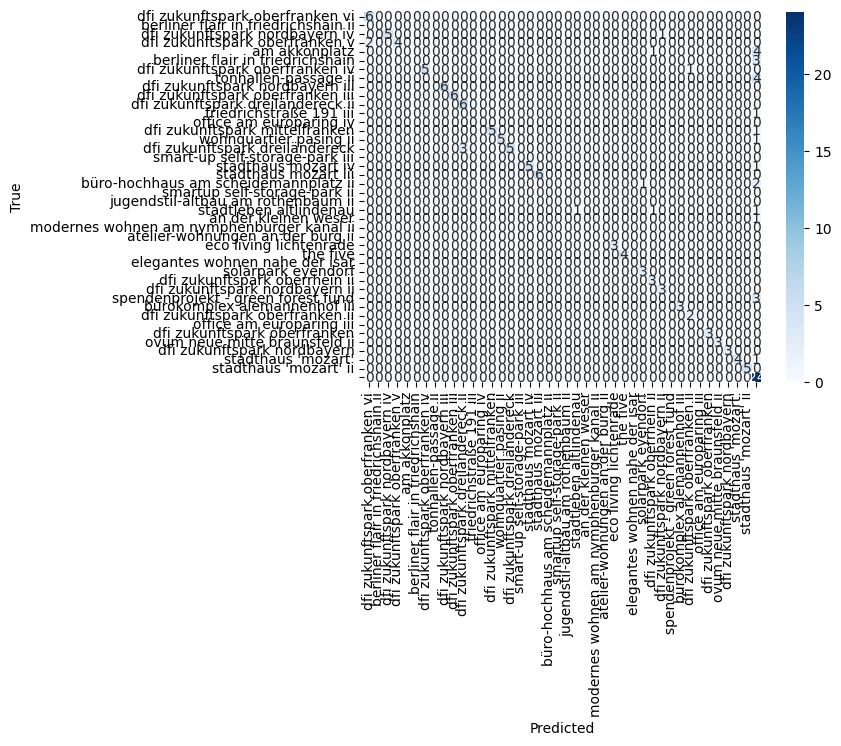

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=df['project_name'].unique())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=df['project_name'].unique(), yticklabels=df['project_name'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## The similarity of the project names

In [37]:
mask = df["project_name"] == df["extracted_project_name"]
correct_predicted_values = df[mask]

correct_predicted_values

,source_system,project_id,project_name,subject,body,extracted_project_name,extracted_project_similarity
0,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,dfi zukunftspark oberfranken vi,Welche Sicherheiten bietet das Projekt DFI Zuk...,"Können Sie mir bitte mitteilen, welche Sicherh...",dfi zukunftspark oberfranken vi,0.415739
1,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,dfi zukunftspark oberfranken vi,Wie ist die Verzinsung für Investoren im Proje...,Ich interessiere mich für die Verzinsung beim ...,dfi zukunftspark oberfranken vi,0.544474
2,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,dfi zukunftspark oberfranken vi,Fragen zur Infrastruktur im Projekt DFI Zukunf...,"Ich möchte wissen, welche infrastrukturellen E...",dfi zukunftspark oberfranken vi,0.500681
3,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,dfi zukunftspark oberfranken vi,Projektlaufzeit und Rückzahlung im DFI Zukunft...,Wie lange ist die geplante Projektlaufzeit bei...,dfi zukunftspark oberfranken vi,0.487222
4,evdi,54EE27F7-BFB3-49BD-9438-2BE412C8D8A0,dfi zukunftspark oberfranken vi,Welche Sicherheiten gibt es im DFI Zukunftspar...,"Mich würde interessieren, welche Sicherheiten ...",dfi zukunftspark oberfranken vi,0.551952
...,...,...,...,...,...,...,...
207,evdi,,,Wann erfolgt die Zinsauszahlung?,Wann werden die Zinszahlungen für mein Investm...,,NaN
208,evdi,,,Wann beginnt die Verzinsung meines Investments?,Wann beginnt die Verzinsung meiner Investition...,,NaN
209,evdi,,,Welche Infrastrukturmaßnahmen sind im Projekt ...,Welche Infrastrukturmaßnahmen werden im Rahmen...,,NaN
210,evdi,,,Wann beginnt die Rückzahlung meines Investments?,Wann wird die Rückzahlung meines Investments e...,,NaN


In [38]:
similarity_min = df["extracted_project_similarity"].min()
similarity_min

np.float64(0.20093679428100586)

In [39]:
df["extracted_project_similarity"].describe()

count    165.000000
mean       0.388992
std        0.116954
min        0.200937
25%        0.287733
50%        0.387963
75%        0.479168
max        0.657667
Name: extracted_project_similarity, dtype: float64

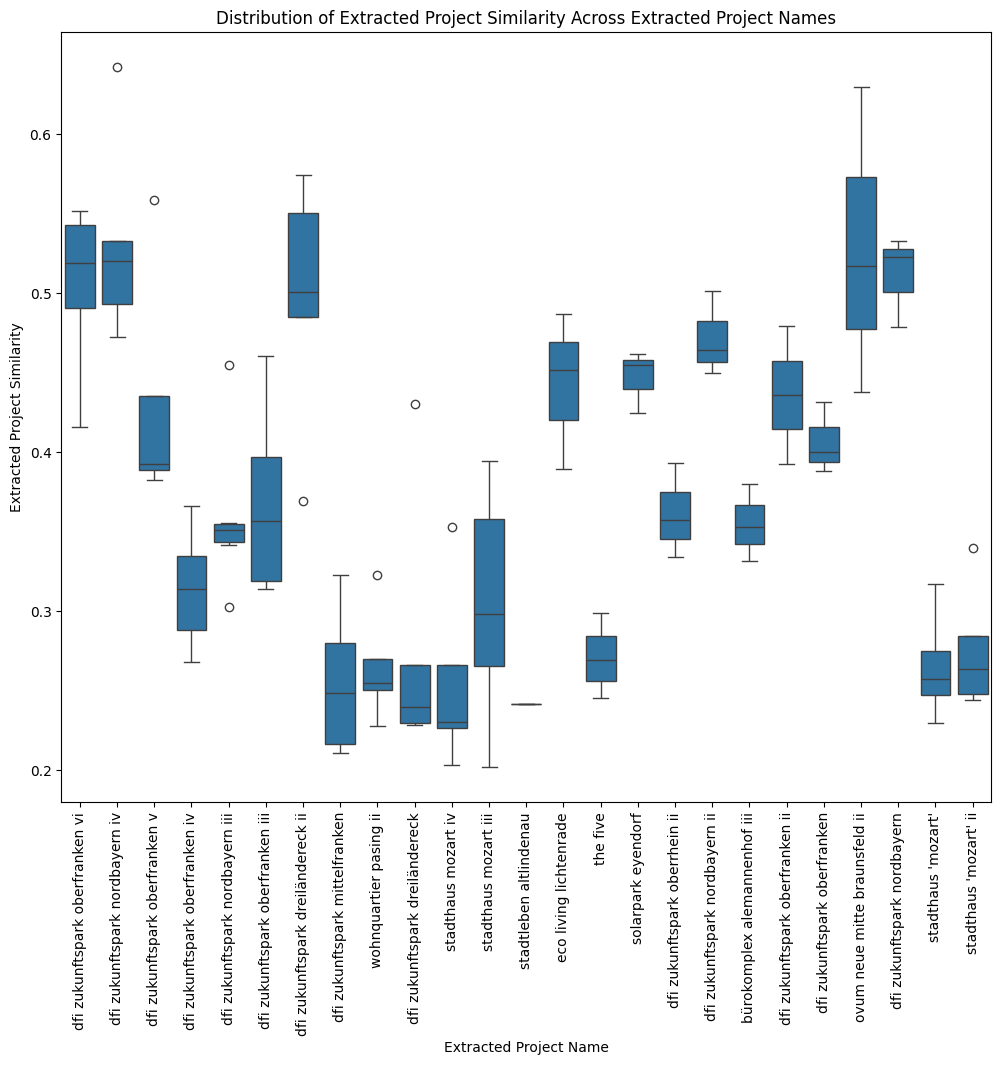

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out rows where 'extracted_project_similarity' is NaN
df_filtered = correct_predicted_values[correct_predicted_values["extracted_project_similarity"].notna()]

# Set the figure size
plt.figure(figsize=(12, 10))

# Create a box plot
sns.boxplot(x="extracted_project_name", y="extracted_project_similarity", data=df_filtered)

# Optionally, create a violin plot instead of a box plot
# sns.violinplot(x="extracted_project_name", y="extracted_project_similarity", data=df_filtered)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set plot title and labels
plt.title("Distribution of Extracted Project Similarity Across Extracted Project Names")
plt.xlabel("Extracted Project Name")
plt.ylabel("Extracted Project Similarity")

# Show the plot
plt.show()